# The Problem:

I am trying to solve a very basic quantum computing problem (No prior QC knowledge needed). I am trying to implement vanilla policy gradient to see if a model can be trained to make any quantum state reach equal superposition. Let me explain:

A random quantum state is in superposition between 0 and 1 with some specific probability. eg, a rough example is 0.2|0> + 0.8|1>. So the probability for 0 is 0.2 and probability for 1 is 0.8. Equal superposition is 0.5|0> + 0.5|1>. So equal probability for 0 and 1. That's it!

Now, the gate sequence that needs to be followed (for any random quantum state) is a measurement and Hadamard gate. This is the sequence that the model needs to learn and I have defined these gates in the method "functions" and I call these gates using the variable "command" as initialised few cells down. 

So I create an "Environment" that randomly initialises a random quantum state and returns that. Then, I create a model and train it according to vanilla PG and I also have a greedy epsilon strategy as "get_exploration_rate". So if you run, the model doesn't seem to converge at all. 


In [1]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from qiskit.quantum_info import random_state
import numpy as np
import random
import matplotlib
import math
import random
from functions import *
import tensorflow as tf
import os
# import objgraph
import sys
import csv
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
'''This is in case you make changes to any python file'''
# %reload_ext autoreload
# %autoreload 2
# from functions import *

'This is in case you make changes to any python file'

In [3]:
# r = [0.0,0.0,0.0,0.0,-1.0]
# gamma = 0.95
# r = np.vstack(r)
# d_rw = discounted_reward(r,gamma)
# print(d_rw)
# d_rw -= np.mean(d_rw)
# d_rw /= np.std(d_rw)
# print(d_rw)

## Creating the environment

In [4]:
class Environment:

    def reset(self):
        state = random_state(2)
        new_state = state_norm(state)
        new_state = np.reshape(new_state.flatten(), (1,1,2))
        return new_state

## The exploration-exploitation rate

In [5]:
# class epsilod_strategy():
#     def __init__(self, start, end, decay):
#         self.start = start
#         self.end = end
#         self.decay = decay
    
def get_exploration_rate(current_step, start, end, decay):

    return max(end, end + (start - end)/math.exp(1.*current_step*decay))

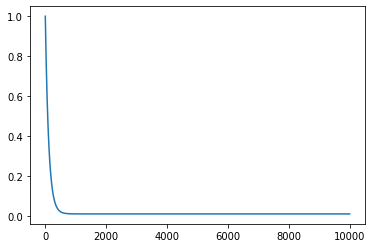

In [6]:
start = 1.0
end = 0.01
decay = 0.009
x = []
for i in range(10000):
    x.append(max(end, get_exploration_rate(i, start, end, decay)))

plt.plot(x)
plt.show()

## The changes I made:

Commenting lines 141 and 142 (basically no standardising the discounting sum of rewards)and changing the formula for "label" in line 150 and replacing it with line 151.

In [58]:
class Agent:
    def __init__(self, state_size, new_state, is_eval=False, model_name=""):
        self.state_size = state_size
        self.action_size = 6 # measurement, CNOT, bit-flip
#         self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.value = new_state
        self.is_eval = is_eval
        self.done = False
#         self.final_state = [1/math.sqrt(2),1/math.sqrt(2)]

        self.gamma = 0.95
        self.epsilon_start = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.009
        self.learning_rate = 0.01
        self.model = self.QC_model()
#         self.model = load_model("model_June_23.h5")
        self.current_step = 0
        self.final_state = np.array([(1/math.sqrt(2))+0j,(1/math.sqrt(2))+0j])

#         self.model = load_model("models/" + model_name) if is_eval else self._model()

# '''
# Method to initialize the network model. It contains 4 fully connected layers, where the last layer gives the
# prbabilities of the gates

# The network will be optmised using sgd optimizer. 

# '''
    def QC_model(self):
        model = Sequential()
        model.add(Dense(units=16, input_shape=self.state_size, activation="relu", name='layer1'))
        model.add(Dense(units=32, activation="relu", name='layer2'))
        model.add(Dense(units=8, activation="relu", name='layer3'))
        model.add(Dense(self.action_size, activation="softmax"))
        model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.003))
        return model
# '''
# This defines how we select the action using exploration-exploitation rate, we defined above. 

# If random is more than the output of the exploration rate, then we select exploration. Else, exploitation. 
# The exploration rate reduces exponentially and we start exploiting rather than exploring by the last epochs. 
# The rate plot can be assesed through the cell the above

# '''

    def act(self, state, episode): #add episode to reduce the epsilon value
        rate = get_exploration_rate(episode, self.epsilon_start, self.epsilon_end, self.epsilon_decay)
        if random.random() <= rate:
            options = self.model.predict(state)
            options = np.squeeze(options)
            action =  random.randrange(self.action_size)
        else:
            options = self.model.predict(state)
            options = np.squeeze(options)
            action = np.where(options == np.amax(options))[0][0]
        return action, options

# '''
# Method to collect data and train the model. 

# '''

    def train(self):

        batch_size = 10
        t = 0                   #increment
        states, prob_actions, dlogps, drs, reward_data =[], [], [], [], []  #initialize the list variables
        tr_x, tr_y = [],[]
        avg_reward = []
        reward_sum = 0
        ep_number = 0
        prev_state = None
        new_state = self.value

        while ep_number<1000:
            print("episode number: ",ep_number)
            print("time step: ",t)
            prev_state = new_state          # Store the initial state
            print("ORIGINAL STATE: ",new_state)
            states.append(new_state)
            action, probs = self.act(new_state, ep_number)        # send the state through the network and get the output
            prob_actions.append(probs)
            y = np.zeros([self.action_size])
            new_state = np.squeeze(new_state)
            y[action] = 1                                   # one hot encoding for the actions
            print("Action: ",command[action])
            new_state = eval(command[action])               # run the command according to the action predicted by the network
            print("NEW STATE: ",new_state)
            print("RESULT:", np.allclose(new_state,self.final_state))
            if(np.allclose(new_state,self.final_state)):    # if the state is equal to the final state
                rw = 1
                drs.append(rw)
                reward_sum+=rw
                self.done = True                                      # set done = True so that we can train the network on the data
            if(t<4 and not np.allclose(new_state,self.final_state)):  # when we are NOT done with the episode and want to store the reward
                rw = reward(new_state, self.final_state)
                drs.append(rw)
                reward_sum+=rw
            elif(t==4):                      # when we have reached the final time stamp for the episode
                self.done = True
                if not np.allclose(new_state, self.final_state):
                    rw = -1
                    drs.append(rw)
                    reward_sum+=rw
            new_state = np.reshape(new_state, (1,1,2))           # get the shape of state according to keras requirements
            print("reward till now: ",reward_sum)
            dlogps.append(np.array(y).astype('float32') * probs)  # multiply one hot encoding to the probabilities
            del(probs, action) 
            t+=1
            if(self.done):                         #### Done State
                ep_number+=1
                ep_x = np.vstack(states)                     # vertially stack the states we used to train the network on
                ep_dlogp = np.vstack(dlogps)                 # vertically stack the action probabilities we got for the states above
                ep_reward = np.vstack(drs)                   # vertically stack the rewards corresponding to the state-action pairs
                disc_rw = discounted_reward(ep_reward,self.gamma)
                print("disc_rw: ", (disc_rw))
                disc_rw = disc_rw.astype('float32')
                tr_y_len = len(ep_dlogp)
                ep_dlogp*=disc_rw
                if ep_number % batch_size == 0:

                    input_tr_y = ep_dlogp
                    input_tr_y = np.reshape(input_tr_y, (tr_y_len,1,6))

                    self.model.train_on_batch(ep_x, input_tr_y)
                    dlogps, drs, states, prob_actions,proj_data, reward_data = [],[],[],[],[],[]
                avg_reward.append((reward_sum))

                print('Episode {:} reward {:.2f}, Last 30ep Avg. rewards {:.2f}.'.format(
                    ep_number,reward_sum,avg_reward[ep_number-1]))
                env = Environment()
                new_state = env.reset()
                t=0
                self.done=False

        return avg_reward

In [59]:
command = ['bit_flip_X(new_state)',
           'bit_flip_Y(new_state)',
           'hadamard_X(new_state)',
           'hadamard_Y(new_state)',
           'measurement(new_state[0],new_state[1])',
           'nothing(new_state)']

In [60]:
# def get_exploration_rate(current_step, start, end, decay):
        
#         return end + (start - end)/math.exp(1.*current_step*decay)

In [61]:
env = Environment()
state = env.reset()

agent = Agent(state[0].shape, state)
final_reward = agent.train()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The `random_state` function is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the `random_statevector` function instead.
  after removing the cwd from sys.path.


episode number:  0
time step:  0
ORIGINAL STATE:  [[[-0.3254944 +0.09502888j -0.70045601+0.62800023j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [-0.72545649+0.51125878j  0.2651379 -0.37686765j]
RESULT: False
reward till now:  0.0
episode number:  0
time step:  1
ORIGINAL STATE:  [[[-0.72545649+0.51125878j  0.2651379 -0.37686765j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  0.0
episode number:  0
time step:  2
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  0.0
episode number:  0
time step:  3
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  hadamard_Y(new_state)
NEW STATE:  [ 0.        -0.70710678j -0.70710678+0.j        ]
RESULT: False
reward till now:  0.0
episode number:  0
time step:  4
ORIGINAL STATE:  [[[ 0.        -0.70710678j -0.70710678+0.j        ]]]
Action:  hadamard_X(new_state)
NEW STATE:  [-0.5-0.5j  0.5-0.5j]
RESULT: False
rewa

time step:  3
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  hadamard_Y(new_state)
NEW STATE:  [ 0.        -0.70710678j -0.70710678+0.j        ]
RESULT: False
reward till now:  -6.0
episode number:  6
time step:  4
ORIGINAL STATE:  [[[ 0.        -0.70710678j -0.70710678+0.j        ]]]
Action:  nothing(new_state)
NEW STATE:  [ 0.        -0.70710678j -0.70710678+0.j        ]
RESULT: False
reward till now:  -7.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 7 reward -7.00, Last 30

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/constant_op.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The `random_state` function is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the `random_statevector` function instead.
  after removing the cwd from sys.path.


Episode 10 reward -10.00, Last 30ep Avg. rewards -10.00.
episode number:  10
time step:  0
ORIGINAL STATE:  [[[-0.54338407-0.03806665j  0.80793879+0.22476565j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.18706844+0.13201613j -0.95552956-0.1858505j ]
RESULT: False
reward till now:  -10.0
episode number:  10
time step:  1
ORIGINAL STATE:  [[[ 0.18706844+0.13201613j -0.95552956-0.1858505j ]]]
Action:  hadamard_Y(new_state)
NEW STATE:  [0.00086121+0.76901093j 0.58231193+0.26369351j]
RESULT: False
reward till now:  -10.0
episode number:  10
time step:  2
ORIGINAL STATE:  [[[0.00086121+0.76901093j 0.58231193+0.26369351j]]]
Action:  bit_flip_Y(new_state)
NEW STATE:  [ 0.26369351-0.58231193j -0.76901093+0.00086121j]
RESULT: False
reward till now:  -10.0
episode number:  10
time step:  3
ORIGINAL STATE:  [[[ 0.26369351-0.58231193j -0.76901093+0.00086121j]]]
Action:  hadamard_Y(new_state)
NEW STATE:  [0.18706844+0.13201613j 0.95552956+0.1858505j ]
RESULT: False
reward till now:  -10.0
episo

Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -21.0
episode number:  21
time step:  4
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -22.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 22 reward -22.00, Last 30ep Avg. rewards -22.00.
episode number:  22
time step:  0
ORIGINAL STATE:  [[[-0.07183387+0.73333701j  0.38550806-0.55537398j]]]
Action:  hadamard_Y(new_state)
NEW STATE:  [-0.44350293+0.24595221j -0.79114293+0.3419145j ]
RESULT: False
reward till now:  -22.0
episode number:  22
time step:  1
ORIGINAL STATE:  [[[-0.44350293+0.24595221j -0.79114293+0.3419145j ]]]
Action:  bit_flip_Y(new_state)
NEW STATE:  [ 0.3419145 +0.79114293j -0.24595221-0.44350293j]
RESULT: False
reward till no

episode number:  33
time step:  4
ORIGINAL STATE:  [[[0.27451394+0.51436512j 0.52071858+0.62363673j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [0.52071858+0.62363673j 0.27451394+0.51436512j]
RESULT: False
reward till now:  -30.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 34 reward -30.00, Last 30ep Avg. rewards -30.00.
episode number:  34
time step:  0
ORIGINAL STATE:  [[[-0.38219835-0.49237509j  0.7053266 +0.33764712j]]]
Action:  bit_flip_Y(new_state)
NEW STATE:  [0.33764712-0.7053266j  0.49237509-0.38219835j]
RESULT: False
reward till now:  -30.0
episode number:  34
time step:  1
ORIGINAL STATE:  [[[0.33764712-0.7053266j  0.49237509-0.38219835j]]]
Action:  hadamard_Y(new_state)
NEW STATE:  [-0.03150247-0.84690299j  0.15057946+0.50900

time step:  1
ORIGINAL STATE:  [[[ 0.65891512+0.71813219j -0.00519797-0.22380796j]]]
Action:  hadamard_Y(new_state)
NEW STATE:  [ 0.30766723+0.51147166j -0.50412062+0.62417947j]
RESULT: False
reward till now:  -40.0
episode number:  44
time step:  2
ORIGINAL STATE:  [[[ 0.30766723+0.51147166j -0.50412062+0.62417947j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [-0.13891353+0.80302662j  0.57402069-0.07969646j]
RESULT: False
reward till now:  -40.0
episode number:  44
time step:  3
ORIGINAL STATE:  [[[-0.13891353+0.80302662j  0.57402069-0.07969646j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.30766723+0.51147166j -0.50412062+0.62417947j]
RESULT: False
reward till now:  -40.0
episode number:  44
time step:  4
ORIGINAL STATE:  [[[ 0.30766723+0.51147166j -0.50412062+0.62417947j]]]
Action:  bit_flip_Y(new_state)
NEW STATE:  [ 0.62417947+0.50412062j -0.51147166+0.30766723j]
RESULT: False
reward till now:  -41.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]


episode number:  55
time step:  2
ORIGINAL STATE:  [[[ 0.07920429-0.26615606j -0.10999116+0.95435296j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -49.0
episode number:  55
time step:  3
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  hadamard_Y(new_state)
NEW STATE:  [ 0.        -0.70710678j -0.70710678+0.j        ]
RESULT: False
reward till now:  -49.0
episode number:  55
time step:  4
ORIGINAL STATE:  [[[ 0.        -0.70710678j -0.70710678+0.j        ]]]
Action:  bit_flip_Y(new_state)
NEW STATE:  [0.        +0.70710678j 0.70710678+0.j        ]
RESULT: False
reward till now:  -50.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.81450625]
 [ 0.857375  ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]

Action:  nothing(new_state)
NEW STATE:  [-0.66488647-0.55762974j -0.10849125-0.48497908j]
RESULT: False
reward till now:  -61.0
episode number:  67
time step:  2
ORIGINAL STATE:  [[[-0.66488647-0.55762974j -0.10849125-0.48497908j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -61.0
episode number:  67
time step:  3
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_Y(new_state)
NEW STATE:  [0.70710678+0.j         0.        +0.70710678j]
RESULT: False
reward till now:  -61.0
episode number:  67
time step:  4
ORIGINAL STATE:  [[[0.70710678+0.j         0.        +0.70710678j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.5+0.5j 0.5-0.5j]
RESULT: False
reward till now:  -62.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.   

reward till now:  -71.0
episode number:  79
time step:  1
ORIGINAL STATE:  [[[-0.66195785+0.07996036j  0.70543515+0.24037345j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [ 0.70543515+0.24037345j -0.66195785+0.07996036j]
RESULT: False
reward till now:  -71.0
episode number:  79
time step:  2
ORIGINAL STATE:  [[[ 0.70543515+0.24037345j -0.66195785+0.07996036j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -71.0
episode number:  79
time step:  3
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  bit_flip_Y(new_state)
NEW STATE:  [0.+0.j 0.+1.j]
RESULT: False
reward till now:  -71.0
episode number:  79
time step:  4
ORIGINAL STATE:  [[[0.+0.j 0.+1.j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [0.+1.j 0.+0.j]
RESULT: False
reward till now:  -72.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0

episode number:  90
time step:  2
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  nothing(new_state)
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -82.0
episode number:  90
time step:  3
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  nothing(new_state)
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -82.0
episode number:  90
time step:  4
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -83.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 91 reward -83.00, Last 30ep Avg. rewards -83.00.
episode number:  91
time step:  0
ORIGINAL STATE:  [[[-0.11330475+0.77886053j  0.60480035+0.12146953j]]]
Action:  bit_flip_Y(new_state)
NEW STATE:  [ 0.12146953-0.60480035j -0.77886053-0.11330475j]
RESULT: False
reward till now:  -83.0
episode number:  91
time step:  1
ORIGINAL STATE:  [[[ 0.12146953-0.60480035j -0.7788

Action:  bit_flip_X(new_state)
NEW STATE:  [0.50648272-0.41761228j 0.35936612+0.66327313j]
RESULT: False
reward till now:  -93.0
episode number:  103
time step:  3
ORIGINAL STATE:  [[[0.50648272-0.41761228j 0.35936612+0.66327313j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [0.35936612+0.66327313j 0.50648272-0.41761228j]
RESULT: False
reward till now:  -93.0
episode number:  103
time step:  4
ORIGINAL STATE:  [[[0.35936612+0.66327313j 0.50648272-0.41761228j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.61224758+0.17370845j -0.10402715+0.7643014j ]
RESULT: False
reward till now:  -94.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 104 reward -94.00, Last 30ep Avg. rewards -94.00.
episode numbe

Action:  hadamard_Y(new_state)
NEW STATE:  [ 0.10041812+0.53509376j -0.80224465+0.24493753j]
RESULT: False
reward till now:  -106.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 116 reward -106.00, Last 30ep Avg. rewards -106.00.
episode number:  116
time step:  0
ORIGINAL STATE:  [[[0.27744657+0.74629627j 0.56059675-0.22758858j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.59258611+0.36678172j -0.20021742+0.68864058j]
RESULT: False
reward till now:  -106.0
episode number:  116
time step:  1
ORIGINAL STATE:  [[[ 0.59258611+0.36678172j -0.20021742

NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -116.0
episode number:  126
time step:  4
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -117.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 127 reward -117.00, Last 30ep Avg. rewards -117.00.
episode number:  127
time step:  0
ORIGINAL STATE:  [[[ 0.31288987-0.45534936j -0.76762405+0.32482335j]]]
Action:  bit_flip_X(new_state)
NEW STATE

NEW STATE:  [-0.26952161-0.55082739j  0.77110793+0.17128882j]
RESULT: False
reward till now:  -125.0
episode number:  135
time step:  3
ORIGINAL STATE:  [[[-0.26952161-0.55082739j  0.77110793+0.17128882j]]]
Action:  bit_flip_Y(new_state)
NEW STATE:  [0.17128882-0.77110793j 0.55082739-0.26952161j]
RESULT: False
reward till now:  -125.0
episode number:  135
time step:  4
ORIGINAL STATE:  [[[0.17128882-0.77110793j 0.55082739-0.26952161j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [0.55082739-0.26952161j 0.17128882-0.77110793j]
RESULT: False
reward till now:  -126.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857

episode number:  144
time step:  3
ORIGINAL STATE:  [[[-0.52233285-0.00332423j -0.02924197+0.85223368j]]]
Action:  nothing(new_state)
NEW STATE:  [-0.52233285-0.00332423j -0.02924197+0.85223368j]
RESULT: False
reward till now:  -130.0
episode number:  144
time step:  4
ORIGINAL STATE:  [[[-0.52233285-0.00332423j -0.02924197+0.85223368j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [-0.02924197+0.85223368j -0.52233285-0.00332423j]
RESULT: False
reward till now:  -131.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.857375  ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 145 reward -131.00, Last 30ep Avg. rewards -131.00.
episode number:  145
time step:  0
ORIGINAL STATE:  [[[-0.55856217-0.4759104j -0.0507287 +0.6774542j]]]
A

Action:  hadamard_Y(new_state)
NEW STATE:  [-0.2924889 +0.60555075j  0.35160875+0.6512525j ]
RESULT: False
reward till now:  -133.0
episode number:  155
time step:  1
ORIGINAL STATE:  [[[-0.2924889 +0.60555075j  0.35160875+0.6512525j ]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -133.0
episode number:  155
time step:  2
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -133.0
episode number:  155
time step:  3
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  hadamard_Y(new_state)
NEW STATE:  [ 0.        -0.70710678j -0.70710678+0.j        ]
RESULT: False
reward till now:  -133.0
episode number:  155
time step:  4
ORIGINAL STATE:  [[[ 0.        -0.70710678j -0.70710678+0.j        ]]]
Action:  bit_flip_Y(new_state)
NEW STATE:  [0.        +0.70710678j 0.70710678+0.j        ]
RESULT: False
reward till now:  -134.0
in discounted reward
disc_rw:  [[ 0.8

ORIGINAL STATE:  [[[-0.5-0.5j  0.5-0.5j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -136.0
episode number:  168
time step:  4
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  hadamard_Y(new_state)
NEW STATE:  [ 0.        -0.70710678j -0.70710678+0.j        ]
RESULT: False
reward till now:  -137.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 169 reward -137.00, Last 30ep Avg. rewards 

Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -148.0
episode number:  180
time step:  2
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -148.0
episode number:  180
time step:  3
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -148.0
episode number:  180
time step:  4
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -149.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 181 reward -149.00, Last 30ep Avg. rewards -149.00.
episode number:  181
time step:  0
ORIGINAL STATE:  [[[-0.24827305-0.72814421j -0.6330137 +0.08637224j]]]
Action:  measurement(new_state[0],new_state[1])
NEW

Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -158.0
in discounted reward
disc_rw:  [[ 0.857375  ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 192 reward -158.00, Last 30ep Avg. rewards -158.00.
episode number:  192
time step:  0
ORIGINAL STATE:  [[[0.29078445-0.17299522j 0.9320966 -0.12927869j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.86470748-0.21373993j -0.45347617-0.03091226j]
RESULT: False
reward till now:  -158.0
episode number:  192
time step:  1
ORIGINAL STATE:  [[[ 0.86470748-0.21373993j -0.45347617-0.03091226j]]]
Action:  nothing(new_state)
NEW STATE:  [ 0.86470748-0.21373993j -0.45347617-0.03091226j]
RESULT: False
reward till now:  -158.0
episode number:  192
time step:  2
ORIGINAL STATE:  [[[ 0.86470748-0.21373993j -0.45347617-0.03091226j]]]
Action:  nothing(new_state)
NEW STATE:  [ 0.86470748-0.21373993j -0.45347617-0.03

Action:  bit_flip_Y(new_state)
NEW STATE:  [0.        +0.70710678j 0.70710678+0.j        ]
RESULT: False
reward till now:  -168.0
episode number:  204
time step:  3
ORIGINAL STATE:  [[[0.        +0.70710678j 0.70710678+0.j        ]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -168.0
episode number:  204
time step:  4
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -167.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.81450625]
 [ 0.857375  ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]]
Episode 205 reward -167.00, Last 30ep Avg. rewards -167.00.
episode number:  205
time step:  0
ORIGINAL 

NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -165.0
episode number:  219
time step:  4
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -164.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.857375  ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.81450625]
 [ 0.857375  ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]]
Episode 220 reward -164.00, Last 30ep Avg. rewards -164.00.
episode number:  220
time step:  0
ORIGINAL STATE:  [[[ 

ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -169.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]]
Episode 233 reward -169.00, Last 30ep Avg. rewards -169.00.
episode number:  233
time step:  0
ORIGINAL STATE:  [[[-0.32938914+0.91879952j  0.20701262+0.06675336j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -169.0
episode number:  233
time step:  1
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -168.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1. 

ORIGINAL STATE:  [[[ 0.80162552+0.20221674j -0.56257885+0.00315587j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.16903152+0.14522036j 0.96463816+0.14075729j]
RESULT: False
reward till now:  -170.0
episode number:  248
time step:  4
ORIGINAL STATE:  [[[0.16903152+0.14522036j 0.96463816+0.14075729j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.80162552+0.20221674j -0.56257885+0.00315587j]
RESULT: False
reward till now:  -171.0
in discounted reward
disc_rw:  [[ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 249 reward -171.00, Last 30e

NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -173.0
in discounted reward
disc_rw:  [[ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]]
Episode 263 reward -173.00, Last 30ep Avg. rewards -173.00.
episode number:  263
time step:  0
ORIGINAL STATE:  [[[-0.00420691+0.66130524j -0.62488372+0.41494339j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [-0.62488372+0.41494339j -0.00420691+0.66130524j]
RESULT: False
reward till now:  -173.0
episode number:  263
time step:  1
ORIGINAL STATE:  [[[-0.62488372+0.41494339j -0.00420691+0.66130524j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -173.0
episode number:  263
time step:  2
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -172.0
in discounted reward
disc_rw:  [

Action:  nothing(new_state)
NEW STATE:  [-0.61448338-0.47019072j  0.63037473+0.06291713j]
RESULT: False
reward till now:  -178.0
episode number:  276
time step:  1
ORIGINAL STATE:  [[[-0.61448338-0.47019072j  0.63037473+0.06291713j]]]
Action:  nothing(new_state)
NEW STATE:  [-0.61448338-0.47019072j  0.63037473+0.06291713j]
RESULT: False
reward till now:  -178.0
episode number:  276
time step:  2
ORIGINAL STATE:  [[[-0.61448338-0.47019072j  0.63037473+0.06291713j]]]
Action:  nothing(new_state)
NEW STATE:  [-0.61448338-0.47019072j  0.63037473+0.06291713j]
RESULT: False
reward till now:  -178.0
episode number:  276
time step:  3
ORIGINAL STATE:  [[[-0.61448338-0.47019072j  0.63037473+0.06291713j]]]
Action:  nothing(new_state)
NEW STATE:  [-0.61448338-0.47019072j  0.63037473+0.06291713j]
RESULT: False
reward till now:  -178.0
episode number:  276
time step:  4
ORIGINAL STATE:  [[[-0.61448338-0.47019072j  0.63037473+0.06291713j]]]
Action:  nothing(new_state)
NEW STATE:  [-0.61448338-0.47019

ORIGINAL STATE:  [[[-0.49815156-0.18989765j  0.75179921-0.38804878j]]]
Action:  nothing(new_state)
NEW STATE:  [-0.49815156-0.18989765j  0.75179921-0.38804878j]
RESULT: False
reward till now:  -183.0
episode number:  289
time step:  3
ORIGINAL STATE:  [[[-0.49815156-0.18989765j  0.75179921-0.38804878j]]]
Action:  nothing(new_state)
NEW STATE:  [-0.49815156-0.18989765j  0.75179921-0.38804878j]
RESULT: False
reward till now:  -183.0
episode number:  289
time step:  4
ORIGINAL STATE:  [[[-0.49815156-0.18989765j  0.75179921-0.38804878j]]]
Action:  nothing(new_state)
NEW STATE:  [-0.49815156-0.18989765j  0.75179921-0.38804878j]
RESULT: False
reward till now:  -184.0
in discounted reward
disc_rw:  [[ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]

time step:  3
ORIGINAL STATE:  [[[0.05750343-0.22137968j 0.94201931+0.24552804j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.7067693 +0.01707547j -0.62544717-0.33015362j]
RESULT: False
reward till now:  -172.0
episode number:  306
time step:  4
ORIGINAL STATE:  [[[ 0.7067693 +0.01707547j -0.62544717-0.33015362j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.05750343-0.22137968j 0.94201931+0.24552804j]
RESULT: False
reward till now:  -173.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 307 reward -173.00, Last 30ep Avg. rewards -173.00.
episode number:  307
time step:  0
ORIGINAL STATE:  [[[ 0.40374507-0.87500867j -0.1477429 +0.22253489j]]]
Action

ORIGINAL STATE:  [[[-0.91638615+0.04871154j  0.39092556+0.07099875j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -160.0
episode number:  324
time step:  1
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -159.0
in discounted reward
disc_rw:  [[0.9025]
 [0.95  ]
 [1.    ]
 [0.9025]
 [0.95  ]
 [1.    ]
 [0.95  ]
 [1.    ]
 [0.9025]
 [0.95  ]
 [1.    ]
 [0.95  ]
 [1.    ]]
Episode 325 reward -159.00, Last 30ep Avg. rewards -159.00.
episode number:  325
time step:  0
ORIGINAL STATE:  [[[-0.06922149+0.53738959j -0.81183752+0.2175791j ]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -159.0
episode number:  325
time step:  1
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -159.0
episode number: 

Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -154.0
in discounted reward
disc_rw:  [[ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.81450625]
 [ 0.857375  ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 340 reward -154.00, Last 30ep Avg. rewards -154.00.
episode number:  340
time step:  0
ORIGINAL STATE:  [[[-0.09681161-0.50863619j  0.58546254-0.62381917j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -154.0
ep

reward till now:  -145.0
in discounted reward
disc_rw:  [[0.9025  ]
 [0.95    ]
 [1.      ]
 [0.857375]
 [0.9025  ]
 [0.95    ]
 [1.      ]
 [0.857375]
 [0.9025  ]
 [0.95    ]
 [1.      ]
 [0.9025  ]
 [0.95    ]
 [1.      ]
 [0.9025  ]
 [0.95    ]
 [1.      ]
 [0.95    ]
 [1.      ]
 [0.95    ]
 [1.      ]]
Episode 357 reward -145.00, Last 30ep Avg. rewards -145.00.
episode number:  357
time step:  0
ORIGINAL STATE:  [[[ 0.14411242+0.76626004j -0.57229672-0.25407405j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -145.0
episode number:  357
time step:  1
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -144.0
in discounted reward
disc_rw:  [[0.9025  ]
 [0.95    ]
 [1.      ]
 [0.857375]
 [0.9025  ]
 [0.95    ]
 [1.      ]
 [0.857375]
 [0.9025  ]
 [0.95    ]
 [1.      ]
 [0.9025  ]
 [0.95    ]
 [1.      ]
 [0.9025  ]
 [0.95    ]
 [

disc_rw:  [[0.9025  ]
 [0.95    ]
 [1.      ]
 [0.9025  ]
 [0.95    ]
 [1.      ]
 [0.9025  ]
 [0.95    ]
 [1.      ]
 [0.95    ]
 [1.      ]
 [0.9025  ]
 [0.95    ]
 [1.      ]
 [0.95    ]
 [1.      ]
 [0.857375]
 [0.9025  ]
 [0.95    ]
 [1.      ]]
Episode 377 reward -127.00, Last 30ep Avg. rewards -127.00.
episode number:  377
time step:  0
ORIGINAL STATE:  [[[-0.0674702 +0.97177074j  0.18972165+0.12294344j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -127.0
episode number:  377
time step:  1
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -126.0
in discounted reward
disc_rw:  [[0.9025  ]
 [0.95    ]
 [1.      ]
 [0.9025  ]
 [0.95    ]
 [1.      ]
 [0.9025  ]
 [0.95    ]
 [1.      ]
 [0.95    ]
 [1.      ]
 [0.9025  ]
 [0.95    ]
 [1.      ]
 [0.95    ]
 [1.      ]
 [0.857375]
 [0.9025  ]
 [0.95    ]
 [1.      ]
 [0.95    ]


ORIGINAL STATE:  [[[0.48679502+0.10047924j 0.18666934+0.84740137j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -116.0
episode number:  396
time step:  1
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -115.0
in discounted reward
disc_rw:  [[ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]]
Episode 397 reward -115.00, Last 30ep Avg. rewards -115.00.
episode number:  397
time step:  0
ORIGINAL STATE:  [[[0.13654728-0.19907853j 0.49538086-0.83445814j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -115.0
episode number:  397
time step:  1
ORIGINAL STATE:

reward till now:  -118.0
episode number:  410
time step:  4
ORIGINAL STATE:  [[[ 0.70710678+0.j -0.70710678+0.j]]]
Action:  bit_flip_Y(new_state)
NEW STATE:  [0.+0.70710678j 0.+0.70710678j]
RESULT: False
reward till now:  -119.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 411 reward -119.00, Last 30ep Avg. rewards -119.00.
episode number:  411
time step:  0
ORIGINAL STATE:  [[[ 0.07593488+0.16965703j -0.44564474+0.87570038j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -119.0
episode number:  411
time step:  1
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.70710678+0.j -0.70710678+0.j]
RESULT: False
reward till now:  -119.0
episode number:  411
time step:  2
ORIGINAL STATE:  [[[ 0.70710678+0.j -0.70710678+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -119.0
episode

Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -122.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]]
Episode 424 reward -122.00, Last 30ep Avg. rewards -122.00.
episode number:  424
time step:  0
ORIGINAL STATE:  [[[0.28453672+0.48151958j 0.30404786-0.77118911j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -122.0
episode number:  424
time step:  1
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -122.0
episode number:  424
time step:  2
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now: 

Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -121.0
in discounted reward
disc_rw:  [[ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]]
Episode 439 reward -121.00, Last 30ep Avg. rewards -121.00.
episode number:  439
time step:  0
ORIGINAL STATE:  [[[0.45680115+0.83413451j 0.04191489-0.30626047j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -121.0
episode number:  439
time step:  1
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678

Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -102.0
in discounted reward
disc_rw:  [[ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]]
Episode 460 reward -102.00, Last 30ep Avg. rewards -102.00.
episode number:  460
time step:  0
ORIGINAL STATE:  [[[ 0.45157086+0.31717076j -0.03490043+0.83322772j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -102.0
episode number:  460
time step:  1
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -101.0

disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 477 reward -99.00, Last 30ep Avg. rewards -99.00.
episode number:  477
time step:  0
ORIGINAL STATE:  [[[0.66204043-0.30494911j 0.56023529+0.3935034j ]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -99.0
episode number:  477
time step:  1
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -98.0
in d

episode number:  493
time step:  2
ORIGINAL STATE:  [[[ 0.70710678+0.j -0.70710678+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -91.0
episode number:  493
time step:  3
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -90.0
in discounted reward
disc_rw:  [[ 0.857375  ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.81450625]
 [ 0.857375  ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.857375  ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]]
Episode 494 reward -90.00, Last 30ep Avg. rewards -90.00.
episode number:  494
time step:  0
ORIGINAL STATE:  [[[0.06918341+0.90976884j 0.06697422-0.40379298j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -90.0
episode number:  494
time step:  1

Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -85.0
episode number:  509
time step:  1
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.70710678+0.j -0.70710678+0.j]
RESULT: False
reward till now:  -85.0
episode number:  509
time step:  2
ORIGINAL STATE:  [[[ 0.70710678+0.j -0.70710678+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -85.0
episode number:  509
time step:  3
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -84.0
in discounted reward
disc_rw:  [[ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.857375  ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450

ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.70710678+0.j -0.70710678+0.j]
RESULT: False
reward till now:  -74.0
episode number:  524
time step:  4
ORIGINAL STATE:  [[[ 0.70710678+0.j -0.70710678+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -75.0
in discounted reward
disc_rw:  [[ 0.81450625]
 [ 0.857375  ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.857375  ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 525 reward -75.00, Last 30ep Avg. rewards -75.00.
episode number:  525
time step:  0
ORIGINAL STATE:  [[[-0.816893 -0.34201102j -0.2840213-0.36748631j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -75.0
episode number:  525
time step:  1
ORIGINAL STATE:  [[[1.+0.j 0.+0

RESULT: False
reward till now:  -73.0
episode number:  539
time step:  4
ORIGINAL STATE:  [[[ 0.70710678+0.j -0.70710678+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -74.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.857375  ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.857375  ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 540 reward -74.00, Last 30ep Avg. rewards -74.00.
episode number:  540
time step:  0
ORIGINAL STATE:  [[[ 0.13632465-0.14932919j -0.96935496-0.13952

episode number:  554
time step:  0
ORIGINAL STATE:  [[[0.70868494-0.11067353j 0.59713702+0.3590883j ]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.92335556+0.17565576j 0.07887628-0.33217177j]
RESULT: False
reward till now:  -72.0
episode number:  554
time step:  1
ORIGINAL STATE:  [[[0.92335556+0.17565576j 0.07887628-0.33217177j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70868494-0.11067353j 0.59713702+0.3590883j ]
RESULT: False
reward till now:  -72.0
episode number:  554
time step:  2
ORIGINAL STATE:  [[[0.70868494-0.11067353j 0.59713702+0.3590883j ]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.92335556+0.17565576j 0.07887628-0.33217177j]
RESULT: False
reward till now:  -72.0
episode number:  554
time step:  3
ORIGINAL STATE:  [[[0.92335556+0.17565576j 0.07887628-0.33217177j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70868494-0.11067353j 0.59713702+0.3590883j ]
RESULT: False
reward till now:  -72.0
episode number:  554
time step:  4
ORIGINAL STATE:  [[[0.70868494-0.

Action:  hadamard_X(new_state)
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -72.0
episode number:  566
time step:  3
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.70710678+0.j -0.70710678+0.j]
RESULT: False
reward till now:  -72.0
episode number:  566
time step:  4
ORIGINAL STATE:  [[[ 0.70710678+0.j -0.70710678+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -73.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 567 reward -73.00, Last 30ep Avg. rewards -73.00.
episode number:  567
time step:  0

Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -79.0
episode number:  579
time step:  1
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.70710678+0.j -0.70710678+0.j]
RESULT: False
reward till now:  -79.0
episode number:  579
time step:  2
ORIGINAL STATE:  [[[ 0.70710678+0.j -0.70710678+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -79.0
episode number:  579
time step:  3
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.70710678+0.j -0.70710678+0.j]
RESULT: False
reward till now:  -79.0
episode number:  579
time step:  4
ORIGINAL STATE:  [[[ 0.70710678+0.j -0.70710678+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -80.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [

episode number:  593
time step:  2
ORIGINAL STATE:  [[[0.88044884-0.33678077j 0.26296239+0.2055221j ]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.80851383-0.09281389j 0.43662886-0.38346603j]
RESULT: False
reward till now:  -83.0
episode number:  593
time step:  3
ORIGINAL STATE:  [[[0.80851383-0.09281389j 0.43662886-0.38346603j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.88044884-0.33678077j 0.26296239+0.2055221j ]
RESULT: False
reward till now:  -83.0
episode number:  593
time step:  4
ORIGINAL STATE:  [[[0.88044884-0.33678077j 0.26296239+0.2055221j ]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.80851383-0.09281389j 0.43662886-0.38346603j]
RESULT: False
reward till now:  -84.0
in discounted reward
disc_rw:  [[ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 594 reward -84.00, Last 30ep Avg. rewards -84.00.
episode number:  594
time step:  0
ORIGINAL ST

Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -83.0
episode number:  609
time step:  3
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -83.0
episode number:  609
time step:  4
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -84.0
in discounted reward
disc_rw:  [[ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-

disc_rw:  [[0.95  ]
 [1.    ]
 [0.95  ]
 [1.    ]
 [0.9025]
 [0.95  ]
 [1.    ]
 [0.95  ]
 [1.    ]]
Episode 624 reward -86.00, Last 30ep Avg. rewards -86.00.
episode number:  624
time step:  0
ORIGINAL STATE:  [[[-0.89192285-0.30675524j  0.30828277-0.12384098j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -86.0
episode number:  624
time step:  1
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -86.0
episode number:  624
time step:  2
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -85.0
in discounted reward
disc_rw:  [[0.95  ]
 [1.    ]
 [0.95  ]
 [1.    ]
 [0.9025]
 [0.95  ]
 [1.    ]
 [0.95  ]
 [1.    ]
 [0.9025]
 [0.95  ]
 [1.    ]]
Episode 625 reward -85.00, Last 30ep Avg. rewards -85.00.
episode number:  625
time step:  0
ORIGINAL STATE:  [[[-0.

time step:  0
ORIGINAL STATE:  [[[0.00584801+0.70904253j 0.02642623-0.70464611j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -73.0
episode number:  643
time step:  1
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -72.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]]
Episode 644 reward -72.00, Last 30ep Avg. rewards -72.00.
episode number:  644
time step:  0
ORIGINAL STATE:  [[[ 0.88271307+0.04084788j -0.46789193+0.01504124j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.29332284+0.03951958j 0.95502195+0.01824805j]
RESULT: False
reward till now:  -72.0
episode number:  644
time step:  1
ORIGINAL STATE:  [[[0.29332284+0.03951958j 0.95502195+0.01824805j]]]
Action:  bit_flip_X(new_s

Episode 660 reward -64.00, Last 30ep Avg. rewards -64.00.
episode number:  660
time step:  0
ORIGINAL STATE:  [[[-0.1577113 -0.4037005j  -0.74057632+0.51351705j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -64.0
episode number:  660
time step:  1
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -63.0
in discounted reward
disc_rw:  [[0.95]
 [1.  ]]
Episode 661 reward -63.00, Last 30ep Avg. rewards -63.00.
episode number:  661
time step:  0
ORIGINAL STATE:  [[[0.44782191-0.23099809j 0.76149518-0.40770149j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [0.76149518-0.40770149j 0.44782191-0.23099809j]
RESULT: False
reward till now:  -63.0
episode number:  661
time step:  1
ORIGINAL STATE:  [[[0.76149518-0.40770149j 0.44782191-0.23099809j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.85511632-0.45162881j 0.2218005 -0.12494817j]
RESU

Action:  bit_flip_X(new_state)
NEW STATE:  [0.54554884-0.54111258j 0.5321482 +0.35551643j]
RESULT: False
reward till now:  -68.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 674 reward -68.00, Last 30ep Avg. rewards -68.00.
episode number:  674
time step:  0
ORIGINAL STATE:  [[[0.551047  +0.10968865j 0.26470761-0.78373815j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.57682561-0.47662497j 0.20247252+0.63174815j]
RESULT: False
reward till now:  -68.0
episode number:  674
time step:  1
ORIGINAL STATE:  [[[0.57682561-0.47662497j 0.20247252+0.63174815j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.551047  +0.10968865j 0.26470761-0.78373815j]
RESULT: False
reward till now:  -68.0
episode number:

Action:  hadamard_X(new_state)
NEW STATE:  [0.26330524+0.21340491j 0.93790919+0.07385833j]
RESULT: False
reward till now:  -75.0
episode number:  687
time step:  2
ORIGINAL STATE:  [[[0.26330524+0.21340491j 0.93790919+0.07385833j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.84938686+0.20312579j -0.47701703+0.09867433j]
RESULT: False
reward till now:  -75.0
episode number:  687
time step:  3
ORIGINAL STATE:  [[[ 0.84938686+0.20312579j -0.47701703+0.09867433j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.26330524+0.21340491j 0.93790919+0.07385833j]
RESULT: False
reward till now:  -75.0
episode number:  687
time step:  4
ORIGINAL STATE:  [[[0.26330524+0.21340491j 0.93790919+0.07385833j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.84938686+0.20312579j -0.47701703+0.09867433j]
RESULT: False
reward till now:  -76.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]


Action:  hadamard_X(new_state)
NEW STATE:  [0.47225262+0.74058706j 0.29746289-0.37419794j]
RESULT: False
reward till now:  -73.0
episode number:  703
time step:  2
ORIGINAL STATE:  [[[0.47225262+0.74058706j 0.29746289-0.37419794j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [0.29746289-0.37419794j 0.47225262+0.74058706j]
RESULT: False
reward till now:  -73.0
episode number:  703
time step:  3
ORIGINAL STATE:  [[[0.29746289-0.37419794j 0.47225262+0.74058706j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [0.47225262+0.74058706j 0.29746289-0.37419794j]
RESULT: False
reward till now:  -73.0
episode number:  703
time step:  4
ORIGINAL STATE:  [[[0.47225262+0.74058706j 0.29746289-0.37419794j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [0.29746289-0.37419794j 0.47225262+0.74058706j]
RESULT: False
reward till now:  -74.0
in discounted reward
disc_rw:  [[ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.9

episode number:  719
time step:  3
ORIGINAL STATE:  [[[0.84385095-0.07841426j 0.34186159+0.40607564j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.83842538+0.23169158j 0.35496008-0.34258609j]
RESULT: False
reward till now:  -69.0
episode number:  719
time step:  4
ORIGINAL STATE:  [[[0.83842538+0.23169158j 0.35496008-0.34258609j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.84385095-0.07841426j 0.34186159+0.40607564j]
RESULT: False
reward till now:  -70.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.857375  ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.814

NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -60.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]]
Episode 738 reward -60.00, Last 30ep Avg. rewards -60.00.
episode number:  738
time step:  0
ORIGINAL STATE:  [[[-0.52600663+0.37917864j -0.0948665 +0.7553416j ]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -60.0
episode number:  738
time step:  1
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -60.0
episode number:  738
time step:  2
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STA

Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -55.0
in discounted reward
disc_rw:  [[ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 753 reward -55.00, Last 30ep Avg. rewards -55.00.
episode number:  753
time step:  0
ORIGINAL STATE:  [[[-0.559712  -0.39582143j  0.61612251+0.38786716j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -55.0
episode number:  753
time step:  1
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -55.0
episode number:  753
time step:  2
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -55.0
episode number:  753
tim

Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -49.0
episode number:  769
time step:  3
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -49.0
episode number:  769
time step:  4
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -50.0
in discounted reward
disc_rw:  [[ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 770 reward -50.00, Last 30ep Avg. rewards -50.00.
epis

RESULT: False
reward till now:  -33.0
episode number:  789
time step:  1
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -32.0
in discounted reward
disc_rw:  [[ 0.857375  ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]]
Episode 790 reward -32.00, Last 30ep Avg. rewards -32.00.
episode number:  790
time step:  0
ORIGINAL STATE:  [[[ 0.06619323+0.32178114j -0.46026789-0.82475986j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -32.0
episode number:  790
time step:  1
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action

time step:  4
ORIGINAL STATE:  [[[ 0.70710678+0.j -0.70710678+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -28.0
in discounted reward
disc_rw:  [[ 0.857375  ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 806 reward -28.00, Last 30ep Avg. rewards -28.00.
episode number:  806
time step:  0
ORIGINAL STATE:  [[[ 0.03252547+0.40423093j -0.68633881+0.60372054j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -28.0
episode number:  806
time step:  1
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -28.0
episode number:  806
time step:  2
ORI

episode number:  820
time step:  1
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.70710678+0.j -0.70710678+0.j]
RESULT: False
reward till now:  -24.0
episode number:  820
time step:  2
ORIGINAL STATE:  [[[ 0.70710678+0.j -0.70710678+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -24.0
episode number:  820
time step:  3
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.70710678+0.j -0.70710678+0.j]
RESULT: False
reward till now:  -24.0
episode number:  820
time step:  4
ORIGINAL STATE:  [[[ 0.70710678+0.j -0.70710678+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -25.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 821 reward -25.00, Last 30ep Avg. rewards -25.00.
episode number:  821
time step:  0
ORIGINAL STATE:  [

Episode 835 reward -21.00, Last 30ep Avg. rewards -21.00.
episode number:  835
time step:  0
ORIGINAL STATE:  [[[ 0.74317922+0.23000568j -0.43861993-0.44988285j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.21535594-0.15547664j 0.8356582 +0.48075379j]
RESULT: False
reward till now:  -21.0
episode number:  835
time step:  1
ORIGINAL STATE:  [[[0.21535594-0.15547664j 0.8356582 +0.48075379j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.74317922+0.23000568j -0.43861993-0.44988285j]
RESULT: False
reward till now:  -21.0
episode number:  835
time step:  2
ORIGINAL STATE:  [[[ 0.74317922+0.23000568j -0.43861993-0.44988285j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.21535594-0.15547664j 0.8356582 +0.48075379j]
RESULT: False
reward till now:  -21.0
episode number:  835
time step:  3
ORIGINAL STATE:  [[[0.21535594-0.15547664j 0.8356582 +0.48075379j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.74317922+0.23000568j -0.43861993-0.44988285j]
RESULT: False
reward till now:  -21.0
ep

time step:  1
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -23.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]]
Episode 849 reward -23.00, Last 30ep Avg. rewards -23.00.
episode number:  849
time step:  0
ORIGINAL STATE:  [[[ 0.50604093-0.40672783j -0.17271115-0.74071986j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.23569975-0.81136804j 0.4799502 +0.236168

Action:  hadamard_X(new_state)
NEW STATE:  [ 0.70710678+0.j -0.70710678+0.j]
RESULT: False
reward till now:  -31.0
episode number:  861
time step:  2
ORIGINAL STATE:  [[[ 0.70710678+0.j -0.70710678+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -31.0
episode number:  861
time step:  3
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [ 0.70710678+0.j -0.70710678+0.j]
RESULT: False
reward till now:  -31.0
episode number:  861
time step:  4
ORIGINAL STATE:  [[[ 0.70710678+0.j -0.70710678+0.j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -32.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 862 reward -32.00, Last 30ep Avg. rewards -32.00.
episode number:  862
time step:  0
ORIGINAL STATE:

Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  -38.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 874 reward -38.00, Last 30ep Avg. rewards -38.00.
episode number:  874
time step:  0
ORIGINAL STATE:  [[[-0.44596789-0.75929633j -0.47207898-0.04151111j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -38.0
episode number:  874
time step:  1
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -37.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 

episode number:  889
time step:  1
ORIGINAL STATE:  [[[0.4754495 +0.63957337j 0.46447531-0.38620766j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -39.0
episode number:  889
time step:  2
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -38.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]]
Episode 890 reward -38.00,

episode number:  905
time step:  0
ORIGINAL STATE:  [[[ 0.2985227 -0.81088832j -0.32406924-0.38512784j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -35.0
episode number:  905
time step:  1
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -34.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]]
Episode 906 reward -34.00, Last 30ep Avg. rewards -34.00.
episode number:  906
time step:  0
ORIGINAL STATE:  [[[-0.44432219+0.04029962j -0.53261659-0.71921714j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: F

ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  -19.0
episode number:  925
time step:  2
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  -18.0
in discounted reward
disc_rw:  [[0.9025]
 [0.95  ]
 [1.    ]
 [0.95  ]
 [1.    ]
 [0.9025]
 [0.95  ]
 [1.    ]
 [0.95  ]
 [1.    ]
 [0.95  ]
 [1.    ]
 [0.9025]
 [0.95  ]
 [1.    ]]
Episode 926 reward -18.00, Last 30ep Avg. rewards -18.00.
episode number:  926
time step:  0
ORIGINAL STATE:  [[[0.83347711+0.11873578j 0.04022443-0.5381447j ]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.61780028-0.29656689j 0.56091435+0.46448464j]
RESULT: False
reward till now:  -18.0
episode number:  926
time step:  1
ORIGINAL STATE:  [[[0.61780028-0.29656689j 0.56091435+0.46448464j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now

Episode 947 reward 1.00, Last 30ep Avg. rewards 1.00.
episode number:  947
time step:  0
ORIGINAL STATE:  [[[-0.70508226+0.15032313j  0.31381964-0.61788283j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  1.0
episode number:  947
time step:  1
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  1.0
episode number:  947
time step:  2
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  2.0
in discounted reward
disc_rw:  [[ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]]
Ep

RESULT: True
reward till now:  9.0
in discounted reward
disc_rw:  [[0.9025    ]
 [0.95      ]
 [1.        ]
 [0.9025    ]
 [0.95      ]
 [1.        ]
 [0.81450625]
 [0.857375  ]
 [0.9025    ]
 [0.95      ]
 [1.        ]
 [0.95      ]
 [1.        ]
 [0.95      ]
 [1.        ]]
Episode 965 reward 9.00, Last 30ep Avg. rewards 9.00.
episode number:  965
time step:  0
ORIGINAL STATE:  [[[-0.26097047+0.64057279j  0.70444491+0.15911719j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [0.+0.j 1.+0.j]
RESULT: False
reward till now:  9.0
episode number:  965
time step:  1
ORIGINAL STATE:  [[[0.+0.j 1.+0.j]]]
Action:  bit_flip_X(new_state)
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  9.0
episode number:  965
time step:  2
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  10.0
in discounted reward
disc_rw:  [[0.9025    ]
 [0.95      ]
 [1.        ]
 [0.9025    ]
 [0.95      ]


RESULT: False
reward till now:  16.0
episode number:  982
time step:  1
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  17.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]]
Episode 983 reward 17.00, Last 30ep Avg. rewards 17.00.
episode number:  983
time step:  0
ORIGINAL STATE:  [[[-0.7630303 -0.11820508j -0.37539162+0.51273136j]]]
Action:  measurement(new_state[0],new_state[1])
NEW STATE:  [1.+0.j 0.+0.j]
RESULT: False
reward till now:  17.0
episode number:  983
time step:  1
ORIGINAL STATE:  [[[1.+0.j 0.+0.j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70710678+0.j 0.70710678+0.j]
RESULT: True
reward till now:  18.0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0

time step:  1
ORIGINAL STATE:  [[[0.67939713-0.5941258j  0.31322737+0.29550412j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70189152-0.21115742j 0.25892112-0.62906335j]
RESULT: False
reward till now:  20.0
episode number:  996
time step:  2
ORIGINAL STATE:  [[[0.70189152-0.21115742j 0.25892112-0.62906335j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.67939713-0.5941258j  0.31322737+0.29550412j]
RESULT: False
reward till now:  20.0
episode number:  996
time step:  3
ORIGINAL STATE:  [[[0.67939713-0.5941258j  0.31322737+0.29550412j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.70189152-0.21115742j 0.25892112-0.62906335j]
RESULT: False
reward till now:  20.0
episode number:  996
time step:  4
ORIGINAL STATE:  [[[0.70189152-0.21115742j 0.25892112-0.62906335j]]]
Action:  hadamard_X(new_state)
NEW STATE:  [0.67939713-0.5941258j  0.31322737+0.29550412j]
RESULT: False
reward till now:  19.0
in discounted reward
disc_rw:  [[ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 0.95      ]
 [

In [62]:
len(final_reward)

1000

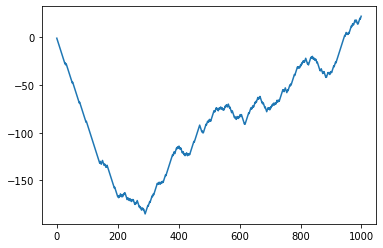

In [63]:
plt.plot(final_reward)
plt.show()

In [64]:
agent.model.save("model_July_7.h5")

# TESTING

Two models have been created, model_June_23 and model_July_7. The former has some issues but the latter seems to be working. One issue with the latter one is that it prefers Hadamard X over Hadamard Y. So need work on that.

In [78]:
model_test = load_model("model_July_7.h5")

In [86]:
env = Environment()
new_state = env.reset()
final_state = np.array([(1/math.sqrt(2))+0j,(1/math.sqrt(2))+0j])
count=0
while not np.allclose(new_state,final_state):
    if (count<=5):
        options = model_test.predict(new_state)
        options = np.squeeze(options)
        action = np.where(options == np.amax(options))[0][0]
        print(command[action].split('(')[0])
        new_state = np.squeeze(new_state)
        new_state = eval(command[action])
        new_state = np.reshape(new_state, (1,1,2))
        count+=1
        print(count)
    
    else:
        break

hadamard_Y
1
hadamard_Y
2
hadamard_Y
3
hadamard_Y
4
hadamard_Y
5
hadamard_Y
6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The `random_state` function is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the `random_statevector` function instead.
  after removing the cwd from sys.path.
